注：本程序在python 3.8.3成功运行

# Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tushare as ts
import operator
import pdb

In [2]:
# functions set
def format_code(df):
    global df_element
    code_list = list(df_element['code'])
    exchange_list = list(df_element['exchange'])
    for i in range(len(code_list)):
        if exchange_list[i] == "SHH":
            code_list[i] = "{:0>6d}.SH".format(code_list[i])
        else:
            code_list[i] = "{:0>6d}.SZ".format(code_list[i])
    return code_list

In [3]:
# my fundamental
class account:
    def __init__(self):
        # initialize for tushare
        ts.set_token("b56903a55b7f98b8ce739e6eff853f726d6add955874aecffeb3995f")
        self.pro = ts.pro_api()
        
        # information about account
        self.origin_fund = 10000000
        self.stocks = {} # code : number, unit of number : hand = 100 stock
        self.cash = self.origin_fund # unit : RMB
        self.unit_position = self.cash
        self.stocks_value = 0
        self.future_value = 0
        self.net_worth = []
        self.price_matrix = []


        # for counting day
        self.day = 0

        self.trade_date_list = []
        self.trade_days_month = []
        self.cal_dates()


    def show_information(self):
        print("current day : ",self.day)
        print("stocks : ")
        print(self.stocks)
        print("current cash : {}".format(self.cash))
        print("stocks value : ",self.stocks_value)
        """
        print("net worth : ")
        print(self.net_worth)
        print("size of net worth : ",len(self.net_worth))
        """

    def cal_dates(self):
        ts.set_token("b56903a55b7f98b8ce739e6eff853f726d6add955874aecffeb3995f")
        pro = ts.pro_api()
        medium = pro.daily(ts_code = '600000.SH', start_date = '20200101', end_date = '20210101')
        self.trade_date_list = list(medium['trade_date'])[::-1]

        start_date_of_month = ['20200102','20200203','20200302','20200401','20200506','20200601','20200701','20200803','20200901','20201009','20201102','20201201']
        last_date = '20201231'
        for i in range(11):
            self.trade_days_month.append(trade_date_list.index(start_date_of_month[i+1]) - trade_date_list.index(start_date_of_month[i]))
        self.trade_days_month.append(trade_date_list.index('20201231') - trade_date_list.index('20201201') + 1)




    def cal_net_worth(self,incre_day = True):
        self.cal_stocks_value()
        self.net_worth.append((self.cash + self.stocks_value + self.future_value)/self.origin_fund)
        if incre_day:
            self.day += 1

    def cal_stocks_value(self):
        # price_list = [self.price_matrix[i][self.day] for i in range(len(self.stocks))]
        price_list = []
        for i in range(len(self.stocks)):
            try:
                price_list.append(self.price_matrix[i][self.day])
            except:
                print("wrong i : ",i)
        
        num_list = list(self.stocks.values())
        self.stocks_value = sum(map(operator.mul,price_list,num_list)) * 100
    
    def cal_price_matrix(self,code_list):
        """
        price_matrix = []
        for code in code_list:
            price_matrix = [self.pro.daily]
        """
        self.price_matrix = [self.pro.daily(ts_code=code, start_date='20200101', end_date='20201231')['close'].tolist()[::-1] for code in code_list]
        print("price matrix shape : {} x {}".format(len(self.price_matrix),len(self.price_matrix[0])))

    # using a series of proportions of cash to buy a series of stocks, the remaining fund return to cash
    def buy(self,date,code_list,proportion_list):
        # every time buy stocks, reset the price matrix
        self.cal_price_matrix(code_list)
        """
        price_list = []
        for i in range(len(code_list)):
            try:
                price_list[i] = self.pro.daily(ts_code = code_list[i], start_date = date, end_date = date)['close'].tolist()[0]
            except:
                price_list[i] = price_list[i-1]
        """
        # price_list = [self.pro.daily(ts_code = code, start_date = date, end_date = date)['close'].tolist()[0] for code in code_list]
        price_list = [self.price_matrix[i][self.trade_date_list.index(date)] for i in range(len(code_list))]
        print('price list : ',price_list)
        const_cash = self.unit_position
        for code,proportion,price in zip(code_list,proportion_list,price_list):
            budget = int(const_cash * proportion)
            num = int(budget/(price*100))
            if code in list(self.stocks.keys()):
                self.stocks[code] += num
            else :
                self.stocks[code] = num
            cost = num * price * 100
            self.cash -= cost

            print("buy information : ")
            print("code : {}, num : {}, cost : {} : ".format(code,num,cost))
            print("current cash : ",self.cash)
            print()

    # when selling a certain stock, sell them all
    def sell(self,date,code_list):
        # price_list = [list(self.pro.daily(ts_code = code, start_date = date, end_date = date)['close'])[0] for code in code_list]
        price_list = []
        """
        for code in code_list:
            # price_list.append(self.pro.daily(ts_code = code, start_date = date, end_date = date)['close'].tolist()[0])
            try:
                price_list[i] = self.pro.daily(ts_code = code_list[i], start_date = date, end_date = date)['close'].tolist()[0]
            except:
                price_list[i] = price_list[i-1]
        """
        price_list = [self.price_matrix[i][self.trade_date_list.index(date)] for i in range(len(code_list))]

        for code,price in zip(code_list,price_list):
            income = self.stocks[code] * price * 100
            self.cash += income
            print("sell information : ")
            print("code : {}, num : {}, income : {}".format(code,self.stocks[code],income))
            print("current cash : ",self.cash)
            print()

            del self.stocks[code]
            
        if len(self.stocks) == 0:
            self.price_matrix.clear()
        else :
            self.cal_price_matrix(list(self.stocks.keys()))


In [4]:
# to get a list of trade date in a year and how many trade days in every month
trade_date_list = []
trade_days_month = []

ts.set_token("b56903a55b7f98b8ce739e6eff853f726d6add955874aecffeb3995f")
pro = ts.pro_api()
medium = pro.daily(ts_code = '600000.SH', start_date = '20200101', end_date = '20210101')
trade_date_list = list(medium['trade_date'])[::-1]

start_date_of_month = ['20200102','20200203','20200302','20200401','20200506','20200601','20200701','20200803','20200901','20201009','20201102','20201201']
last_date = '20201231'
trade_days_month = []
for i in range(11):
    trade_days_month.append(trade_date_list.index(start_date_of_month[i+1]) - trade_date_list.index(start_date_of_month[i]))
trade_days_month.append(trade_date_list.index('20201231') - trade_date_list.index('20201201') + 1)
print(trade_days_month)
print("total day : ",sum(trade_days_month))

[16, 20, 22, 21, 18, 20, 23, 21, 22, 16, 21, 23]
total day :  243


In [5]:
# basic
df_element = pd.read_excel(r'Data/沪深300成分股-2020.xls')
name_list = df_element['name']
code_list = df_element['code']
exchange_list = df_element['exchange']


In [6]:
# get a list of date and index of CSI300
df_hs300_data = pd.read_excel(r'Data/hs300_data_origin.xlsx')
date = pd.to_datetime(df_hs300_data['Date'],unit = 'd', origin = '1899-12-30')
# there are 243 days when stock market run
date = date[:243]
close_price_hs300 = df_hs300_data['closing price'][:243] # 指数
print(date)


0     2020-12-31
1     2020-12-30
2     2020-12-29
3     2020-12-28
4     2020-12-25
         ...    
238   2020-01-08
239   2020-01-07
240   2020-01-06
241   2020-01-03
242   2020-01-02
Name: Date, Length: 243, dtype: datetime64[ns]


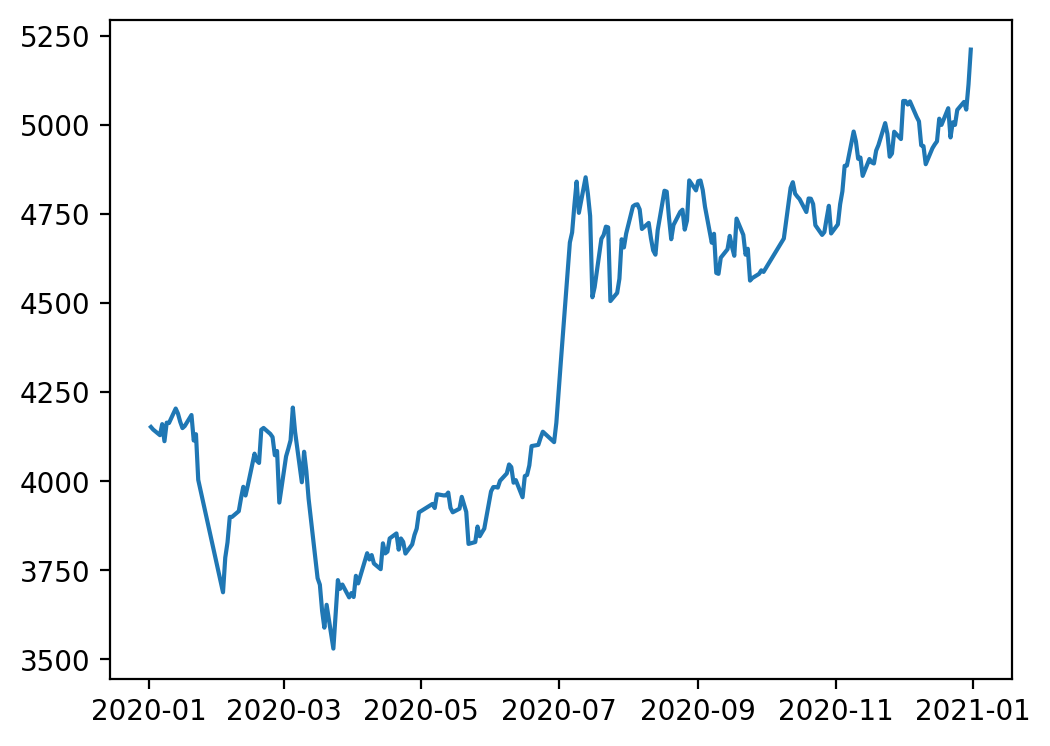

In [7]:
# plot the net worth graph of CSI300
fig = plt.figure(figsize=(12.8,9.6),dpi = 200,facecolor='w')
# plt.plot(date,index)
ax = fig.add_subplot(221,alpha = 0.5)
ax.plot(date,close_price_hs300)

In [8]:
# deal with the format of data
df_10_year_element = pd.read_excel(r'Data/hs300历年成分.xlsx')
df_10_year_element['c10'] = format_code(df_element)
df_element['code'] = format_code(df_element)
panel = list(df_10_year_element['c10'])
print("df element",df_element)
print("10 year, 2020",df_10_year_element['c10'])
print("10 year",df_10_year_element)

df element          日期Date  指数代码Index Code 指数名称Index Name 指数英文名称Index Name(Eng.)  \
0    2020-12-31             300          沪深300                CSI 300   
1    2020-12-31             300          沪深300                CSI 300   
2    2020-12-31             300          沪深300                CSI 300   
3    2020-12-31             300          沪深300                CSI 300   
4    2020-12-31             300          沪深300                CSI 300   
..          ...             ...            ...                    ...   
295  2020-12-31             300          沪深300                CSI 300   
296  2020-12-31             300          沪深300                CSI 300   
297  2020-12-31             300          沪深300                CSI 300   
298  2020-12-31             300          沪深300                CSI 300   
299  2020-12-31             300          沪深300                CSI 300   

          code  name                   成分券英文名称Constituent Name(Eng.) exchange  
0    600000.SH  浦发银行         Sha

In [9]:
# sort out stocks that haven't been died out
for i in panel:
    for j in range(10):
        if i not in list(df_10_year_element['c{}'.format(j+1)]):
            panel.remove(i)
            break

In [10]:
# finally get the name of those stocks exist more than 10 years and their corresponding code
"""
print("number : ",len(panel))
# get their names
panel_name = []
panel_dict = {}
for i in range(300):
    if list(df_element['code'])[i] in panel:
        panel_dict['{}'.format(list(df_element['code'])[i])] = df_element['name'][i]
"""
panel_dict = {'600000.SH': '浦发银行', '600009.SH': '上海机场', '600010.SH': '包钢股份', '600015.SH': '华夏银行', '600016.SH': '民生银行', '600019.SH': '宝钢股份', '600027.SH': '华电国际', '600028.SH': '中国石化', '600029.SH': '南方航空', '600030.SH': '中信证券', '600031.SH': '三一重工', '600036.SH': '招商银行', '600048.SH': '保利地产', '600050.SH': '中国联通', '600066.SH': '宇通客车', '600068.SH': '葛洲坝', '600085.SH': '同仁堂', '600104.SH': '上汽集团', '600109.SH': '国金证券', '600111.SH': '北方稀土', '600115.SH': '东方航空', '600118.SH': '中国卫星', '600161.SH': '天坛生物', '600177.SH': '雅戈尔', '600196.SH': '复星医药', '600208.SH': '新湖中宝', '600271.SH': '航天信息', '600276.SH': '恒瑞医药', '600299.SH': '安迪苏', '600309.SH': '万华化学', '600340.SH': '华夏幸福', '600352.SH': '浙江龙盛', '600362.SH': '江西铜业', '600369.SH': '西南证券', '600383.SH': '金地集团', '600406.SH': '国电南瑞', '600438.SH': '通威股份', '600487.SH': '亨通光电', '600489.SH': '中金黄金', '600519.SH': '贵州茅台', '600547.SH': '山东黄金', '600584.SH': '长电科技', '600585.SH': '海螺水泥', '600588.SH': '用友网络', '600606.SH': '绿地控股', '600655.SH': '豫园股份', '600660.SH': '福耀玻璃', '600690.SH': '海尔智家', '600703.SH': '三安光电', '600741.SH': '华域汽车', '600760.SH': '中航沈飞', '600795.SH': '国电电力', '600837.SH': '海通证券', '600848.SH': '上海临港', '600886.SH': '国投电力', '600887.SH': '伊利股份', '600893.SH': '航发动力', '600900.SH': '长江电力', '600919.SH': '江苏银行', '600958.SH': '东方证券', '600998.SH': '九州通', '600999.SH': '招商证券', '601006.SH': '大秦铁路', '601009.SH': '南京银行', '601021.SH': '春秋航空', '601077.SH': '渝农商行', '601088.SH': '中国神华', '601108.SH': '财通证券', '601111.SH': '中国国航', '601138.SH': '工业富联', '601162.SH': '天风证券', '601166.SH': '兴业银行', '601169.SH': '北京银行', '601186.SH': '中国铁建', '601211.SH': '国泰君安', '601225.SH': '陕西煤业', '601231.SH': '环旭电子', '601238.SH': '广汽集团', '601288.SH': '农业银行', '601318.SH': '中国平安', '601328.SH': '交通银行', '601360.SH': '三六零', '601377.SH': '兴业证券', '601390.SH': '中国中铁', '601398.SH': '工商银行', '601577.SH': '长沙银行', '601600.SH': '中国铝业', '601601.SH': '中国太保', '601607.SH': '上海医药', '601618.SH': '中国中冶', '601628.SH': '中国人寿', '601658.SH': '邮储银行', '601668.SH': '中国建筑', '601688.SH': '华泰证券', '601698.SH': '中国卫通', '601766.SH': '中国中车', '601800.SH': '中国交建', '601816.SH': '京沪高铁', '601818.SH': '光大银行', '601857.SH': '中国石油', '601877.SH': '正泰电器', '601881.SH': '中国银河', '601888.SH': '中国中免', '601899.SH': '紫金矿业', '601916.SH': '浙商银行', '601933.SH': '永辉超市', '601939.SH': '建设银行', '601988.SH': '中国银行', '601989.SH': '中国重工', '601998.SH': '中信银行', '603087.SH': '甘李药业', '603160.SH': '汇顶科技', '603259.SH': '药明康德', '603369.SH': '今世缘', '603501.SH': '韦尔股份', '603799.SH': '华友钴业', '603899.SH': '晨光文具', '603993.SH': '洛阳钼业', '688009.SH': '中国通号', '688036.SH': '传音控股', '000001.SZ': '平安银行', '000002.SZ': '万科A', '000063.SZ': '中兴通讯', '000069.SZ': '华侨城A', '000100.SZ': 'TCL科技', '000157.SZ': '中联重科', '000333.SZ': '美的集团', '000338.SZ': '潍柴动力', '000425.SZ': '徐工机械', '000538.SZ': '云南白药', '000568.SZ': '泸州老窖', '000625.SZ': '长安汽车', '000651.SZ': '格力电器', '000661.SZ': '长春高新', '000703.SZ': '恒逸石化', '000723.SZ': '美锦能源', '000725.SZ': '京东方A', '000728.SZ': '国元证券', '000768.SZ': '中航西飞', '000776.SZ': '广发证券', '000783.SZ': '长江证券', '000858.SZ': '五 粮 液', '000876.SZ': '新 希 望', '000895.SZ': '双汇发展', '000961.SZ': '中南建设', '000977.SZ': '浪潮信息', '002001.SZ': '新和成', '002007.SZ': '华兰生物', '002024.SZ': '苏宁易购', '002032.SZ': '苏泊尔', '002049.SZ': '紫光国微', '002120.SZ': '韵达股份', '002142.SZ': '宁波银行', '002146.SZ': '荣盛发展', '002157.SZ': '正邦科技', '002202.SZ': '金风科技', '002236.SZ': '大华股份', '002252.SZ': '上海莱士', '002304.SZ': '洋河股份', '002352.SZ': '顺丰控股', '002384.SZ': '东山精密', '002414.SZ': '高德红外', '002415.SZ': '海康威视', '002456.SZ': '欧菲光', '002463.SZ': '沪电股份', '002493.SZ': '荣盛石化', '002555.SZ': '三七互娱', '002594.SZ': '比亚迪', '002601.SZ': '龙蟒佰利', '002607.SZ': '中公教育', '002673.SZ': '西部证券', '002736.SZ': '国信证券', '002773.SZ': '康弘药业', '002821.SZ': '凯莱英', '002916.SZ': '深南电路', '002939.SZ': '长城证券', '002958.SZ': '青农商行', '300003.SZ': '乐普医疗', '300015.SZ': '爱尔眼科', '300059.SZ': '东方财富', '300124.SZ': '汇川技术', '300142.SZ': '沃森生物', '300347.SZ': '泰格医药', '300413.SZ': '芒果超媒', '300498.SZ': '温氏股份', '300601.SZ': '康泰生物', '300676.SZ': '华大基因'}

# Part I random sample

In [11]:

randpick_n = 5
# return a list of code
def random_pick(panel_dict, randpick_n):
    code_list = list(panel_dict.keys())
    return np.random.choice(code_list,randpick_n,replace = False)
stocks = random_pick(panel_dict,randpick_n)
print(stocks)


['600276.SH' '600309.SH' '600066.SH' '000651.SZ' '000001.SZ']


In [12]:
# stocks = ['600585.SH', '601318.SH', '600837.SH', '000961.SZ', '000538.SZ', '000069.SZ', '000703.SZ']
# sometimes it will go wrong, this is a bug but I have no time to fix it, so, just try several more times
me_1 = account()
me_1.buy('20200102',stocks,[1/(len(stocks)) for i in range(len(stocks))])
for i in range(243):
    me_1.cal_net_worth()
me_1.show_information()

ProxyError: HTTPConnectionPool(host='127.0.0.1', port=4780): Max retries exceeded with url: http://api.waditu.com/ (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response')))

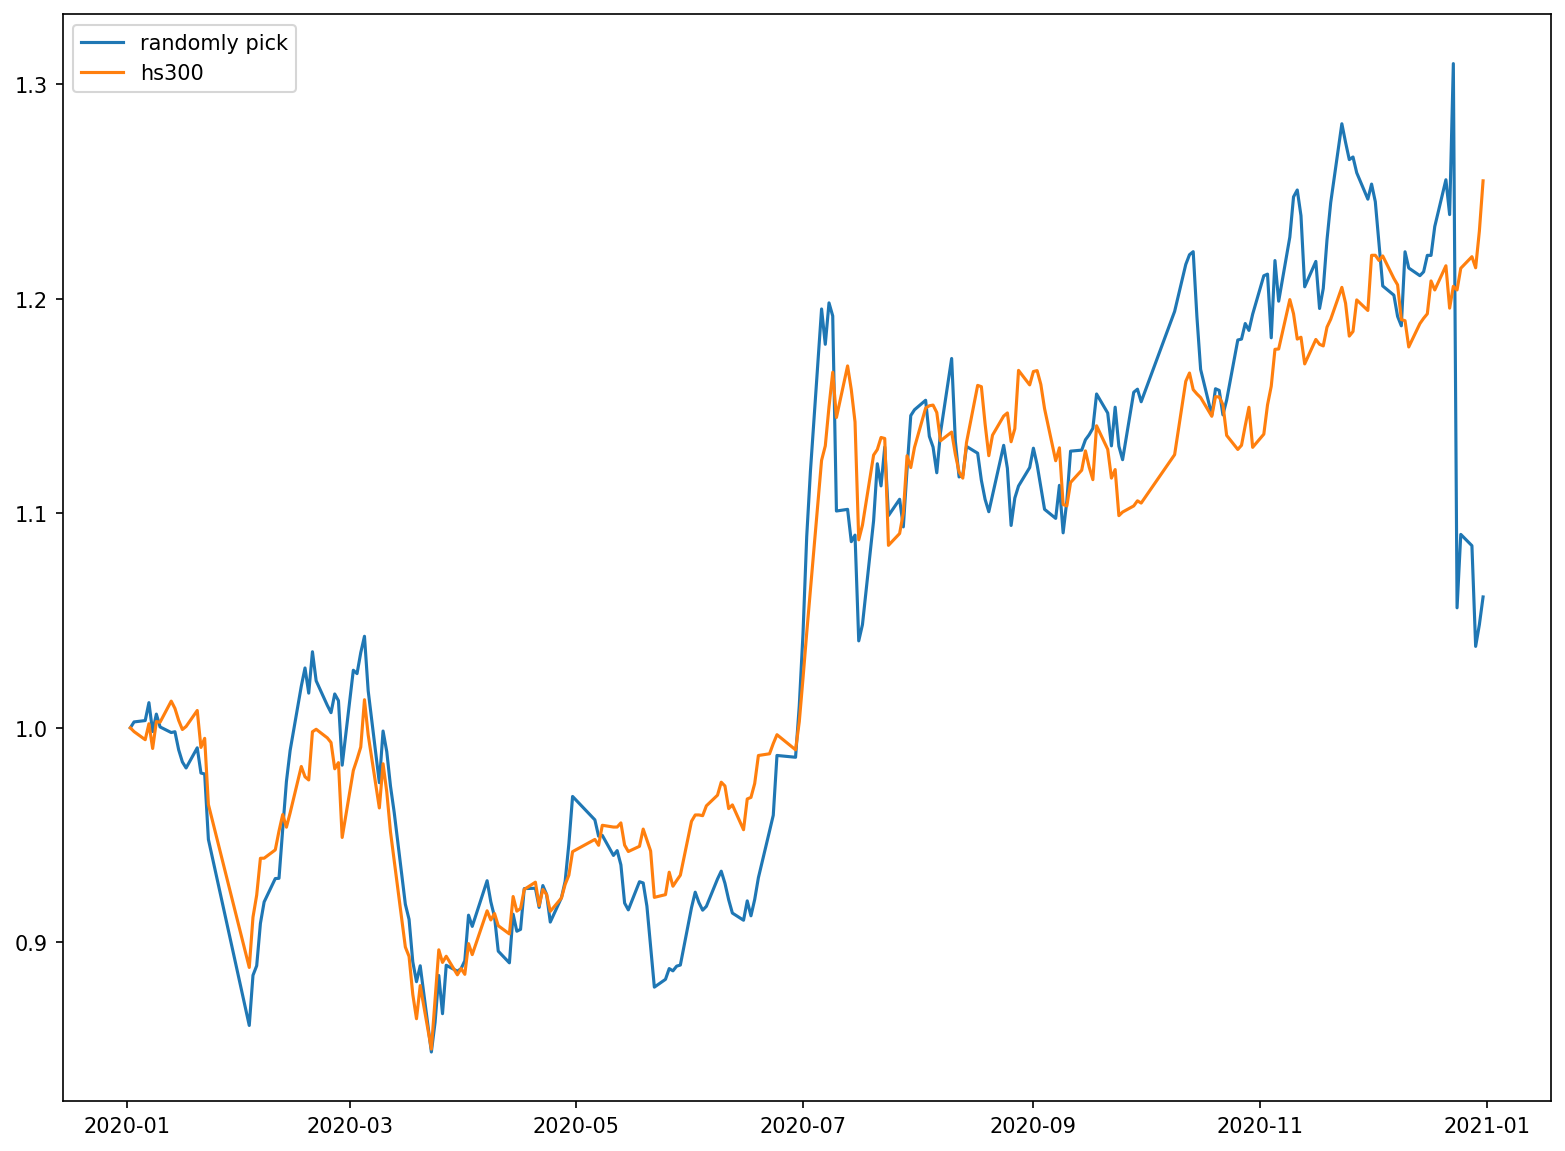

In [ ]:
fig = plt.figure(figsize = (12.8,9.6),dpi = 150)
ax = fig.add_subplot(111)
ax.plot(date,me_1.net_worth[::-1],label = "randomly pick")
ax.plot(date,[i/close_price_hs300[len(close_price_hs300)-1] for i in close_price_hs300], label = "hs300")
ax.legend()

In [ ]:
# for testing basic function of class account
test = account()
test.buy('20200102',stocks,[1/(len(stocks)) for i in range(len(stocks))])
test.show_information()
test.cal_net_worth()
test.show_information()
test.sell('20200102',stocks)
test.show_information()
test.cal_net_worth()
test.show_information()

price matrix shape : 5 x 243
price list :  [14.15, 14.54, 8.17, 6.06, 18.43]
buy information : 
code : 600438.SH, num : 1413, cost : 1999395.0 : 
current cash :  8000605.0

buy information : 
code : 600383.SH, num : 1375, cost : 1999250.0 : 
current cash :  6001355.0

buy information : 
code : 601006.SH, num : 2447, cost : 1999199.0000000002 : 
current cash :  4002156.0

buy information : 
code : 601390.SH, num : 3300, cost : 1999800.0 : 
current cash :  2002356.0

buy information : 
code : 600999.SH, num : 1085, cost : 1999655.0 : 
current cash :  2701.0

current day :  0
stocks : 
{'600438.SH': 1413, '600383.SH': 1375, '601006.SH': 2447, '601390.SH': 3300, '600999.SH': 1085}
current cash : 2701.0
stocks value :  0
current day :  1
stocks : 
{'600438.SH': 1413, '600383.SH': 1375, '601006.SH': 2447, '601390.SH': 3300, '600999.SH': 1085}
current cash : 2701.0
stocks value :  9997299.0
sell information : 
code : 600438.SH, num : 1413, income : 1999395.0
current cash :  2002096.0

sell in

In [ ]:
# in continuous 12 month, every month sell out all stocks in hand and buy randomly picking stocks
me_2 = account()

# generate random proportion list

rand_n = np.random.random(randpick_n)
proportion_list = [i/sum(rand_n) for i in rand_n]


for i in range(12):
    stocks = random_pick(panel_dict,randpick_n)
    rand_n = np.random.random(randpick_n)
    proportion_list = [i/sum(rand_n) for i in rand_n]   
    if i > 0:
        me_2.sell(start_date_of_month[i],list(me_2.stocks.keys()))
    me_2.buy(start_date_of_month[i],stocks,proportion_list)
    for j in range(trade_days_month[i]):
        me_2.cal_net_worth()
        me_2.show_information()

    
me_2.show_information()


price matrix shape : 5 x 243
price list :  [38.88, 7.28, 4.37, 20.85, 21.88]
buy information : 
code : 600036.SH, num : 716, cost : 2783808.0 : 
current cash :  7216192.0

buy information : 
code : 601162.SH, num : 1597, cost : 1162616.0 : 
current cash :  6053576.0

buy information : 
code : 603993.SH, num : 2045, cost : 893665.0 : 
current cash :  5159911.0

buy information : 
code : 000876.SZ, num : 321, cost : 669285.0 : 
current cash :  4490626.0

buy information : 
code : 002414.SZ, num : 2049, cost : 4483212.0 : 
current cash :  7414.0

current day :  1
stocks : 
{'600036.SH': 716, '601162.SH': 1597, '603993.SH': 2045, '000876.SZ': 321, '002414.SZ': 2049}
current cash : 7414.0
stocks value :  9992586.0
current day :  2
stocks : 
{'600036.SH': 716, '601162.SH': 1597, '603993.SH': 2045, '000876.SZ': 321, '002414.SZ': 2049}
current cash : 7414.0
stocks value :  10312222.0
current day :  3
stocks : 
{'600036.SH': 716, '601162.SH': 1597, '603993.SH': 2045, '000876.SZ': 321, '002414.S

IndexError: list index out of range

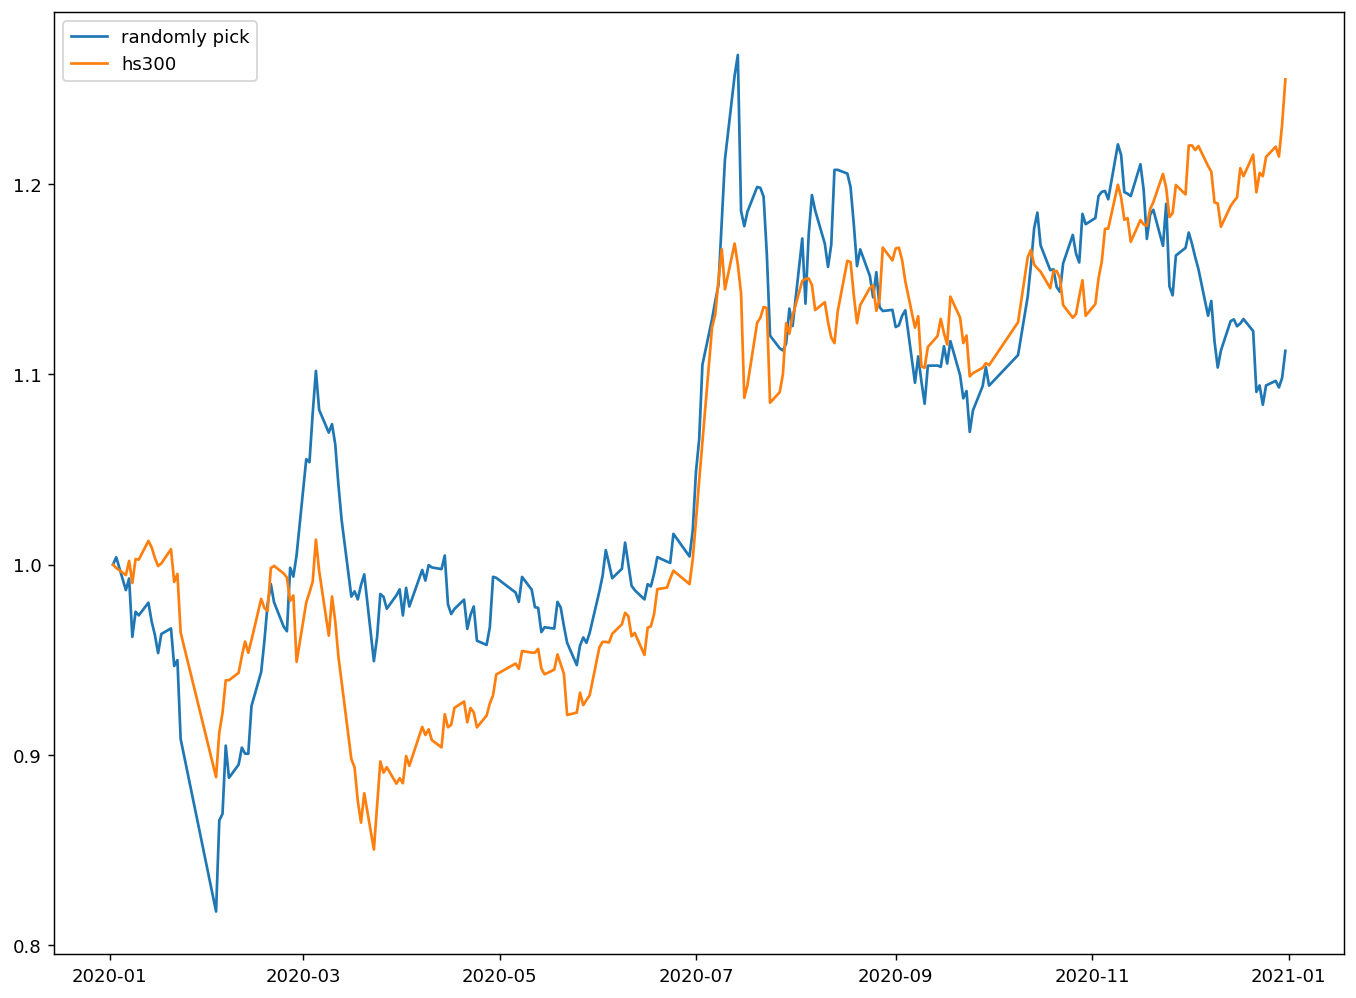

In [ ]:
fig = plt.figure(figsize = (12.8,9.6),dpi = 130)
ax = fig.add_subplot(111)
ax.plot(date,me_2.net_worth[::-1],label = "randomly pick")
ax.plot(date,[i/close_price_hs300[len(close_price_hs300)-1] for i in close_price_hs300], label = "hs300")
ax.legend()

In [ ]:
"""
sun = account()
stocks = ['000690.SZ','600066.SH','600006.SH','000800.SZ']
sun.buy('20200102',stocks,[1/4 for i in range(4)])
for i in range(trade_days_month[0] + trade_days_month[1]):
    sun.cal_net_worth()
sun.sell(start_date_of_month[2],stocks)
sun.buy(start_date_of_month[2],['601666.SH'],[0.7])
for i in range(2,12):
    for j in range(trade_days_month[i]):
        sun.cal_net_worth()
sun.show_information()
"""

cyanic = account()

# January
buy_stocks_in_month_1 = ['002714','600519','000858','300122','600196']
buy_proportion_list_in_month_1 = [0.1,0.1,0.1,0.1,0.1]

cyanic.buy('20200102',buy_stocks_in_month_1,buy_proportion_list_in_month_1)
for i in range(trade_days_month[0]):
    cyanic.cal_net_worth()

# February to March
buy_stocks_in_month_2 = ['300122','600196']
buy_proportion_list_in_month_2 = [0.1,0.1]
cyanic.buy(start_date_of_month[1],buy_proportion_list_in_month_2,buy_stocks_in_month_2)

for i in range(1,3):
    for j in range(trade_date_list[i]):
        cyanic.cal_net_worth()

# May to June
sell_stocks_in_month_5 = ['002714']
cyanic.sell(start_date_of_month[4],sell_stocks_in_month_5)

buy_stocks_in_month_5 = ['600519']
buy_proportion_list_in_month_5 = [0.2]
cyanic.buy(start_date_of_month[4],buy_stocks_in_month_5,buy_proportion_list_in_month_5)

for i in range(4,5):
    for j in range(trade_date_list[i]):
        cyanic.cal_net_worth()

# July to the end
sell_stocks_in_month_7 = ['600519']
cyanic.sell('20200708',sell_stocks_in_month_7)

buy_stocks_in_month_7 = ['600196']
buy_proportion_list_in_month_7 = [0.3]
cyanic.buy('20200708',buy_stocks_in_month_7,buy_proportion_list_in_month_7)

for i in range(trade_date_list.index('20200708') - trade_date_list.index(start_date_of_month[6]) + 1):
    cyanic.cal_net_worth()

sell_stocks_in_month_7 = ['300122']
cyanic.sell('20200730',sell_stocks_in_month_7)

for i in range(trade_date_list.index('20200731') - trade_date_list.index('20201231'))
    cyanic.cal_net_worth()




price matrix shape : 4 x 243
price list :  [5.72, 14.42, 4.65, 10.15]
buy information : 
code : 000690.SZ, num : 4370, cost : 2499640.0 : 
current cash :  7500360.0

buy information : 
code : 600066.SH, num : 1733, cost : 2498986.0 : 
current cash :  5001374.0

buy information : 
code : 600006.SH, num : 5376, cost : 2499840.0 : 
current cash :  2501534.0

buy information : 
code : 000800.SZ, num : 2463, cost : 2499945.0 : 
current cash :  1589.0

sell information : 
code : 000690.SZ, num : 4370, income : 2355430.0
current cash :  2357019.0

sell information : 
code : 600066.SH, num : 1733, income : 2679218.0
current cash :  5036237.0

sell information : 
code : 600006.SH, num : 5376, income : 2252544.0
current cash :  7288781.0

sell information : 
code : 000800.SZ, num : 2463, income : 2302905.0
current cash :  9591686.0

price matrix shape : 1 x 243
price list :  [4.06]
buy information : 
code : 601666.SH, num : 17241, cost : 6999845.999999999 : 
current cash :  2591840.000000001

cu

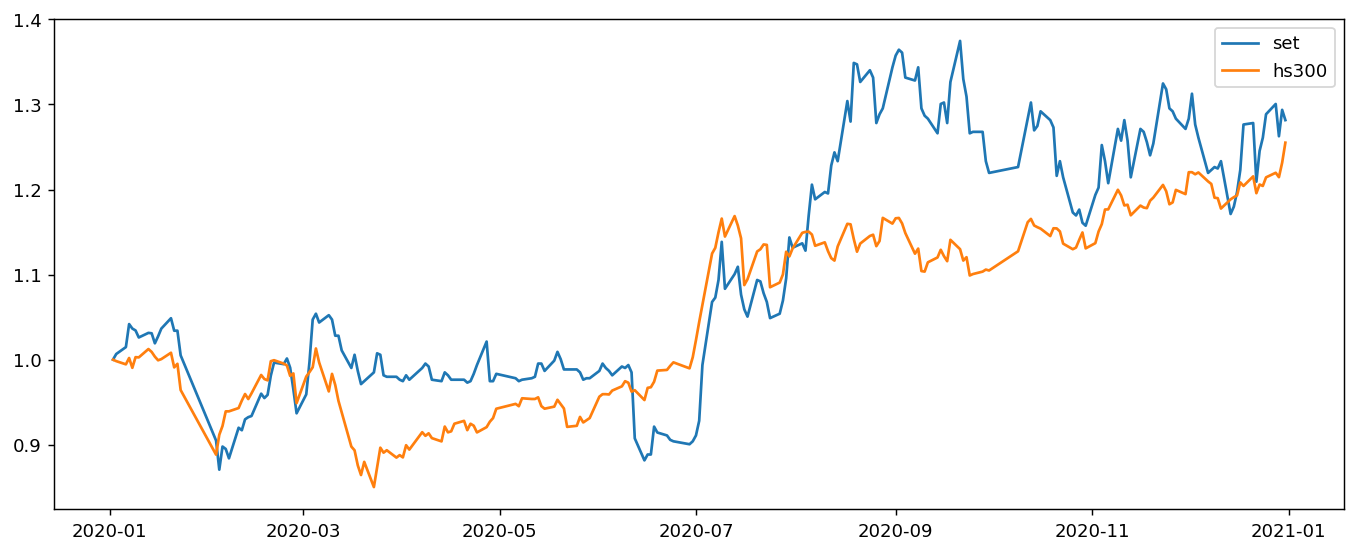

In [ ]:
fig = plt.figure(figsize = (12.8,5),dpi = 130)
ax = fig.add_subplot(111)
ax.plot(date,cyanic.net_worth[::-1],label = "set")
ax.plot(date,[i/close_price_hs300[len(close_price_hs300)-1] for i in close_price_hs300], label = "hs300")
ax.legend()